In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(unglue))
suppressMessages(library(xtable))
theme_set(theme_classic(22))


In [2]:
#paths to files
files <- fs::dir_ls("output/sweep_regions", regexp = "csv$")
#extract variables from path names
unglue_str <- "output/sweep_regions/rep-{rep}_seed1-{seed1}_seed2-{seed2}_startfreq-{start_freq}_endfreq-{end_freq}_alpha-{alpha}_sub-{sub}.csv"
metadata_df <- map_df(files, ~ {
    df  <- unglue(.x, unglue_str)[[1]]
    mutate(df, file = .x)
})

#merge all the sweep regions and classify sim type
full_df <- map(files, ~ {
    suppressMessages(
        vroom::vroom(.x) %>% 
        mutate(file = .x) %>% 
        filter_all(any_vars(!is.na(.)))
    )
}) %>% 
reduce(bind_rows) %>% 
inner_join(., metadata_df, by = "file") %>% 
mutate(sim_type = 
    case_when(
        alpha == "0" ~ "neutral",
        start_freq == "0.0" & end_freq == "0.999" ~ "hard",
        end_freq == "0.5" ~ "incomplete",
        start_freq != "0.999" & !is.na(start_freq) ~ "soft"
    )
) %>% 
    arrange(sweep_size) %>% 
    filter(alpha != '0') %>% 
    group_by(alpha, sim_type) %>% 
    mutate(
        specificity_1m = 1 - cumsum(truth_class == "false_positive")/sum(truth_class == "false_positive", na.rm = TRUE) #cumulative false pos fraction
    )  %>% 
    arrange(specificity_1m) %>% 
    mutate(sensitivity = cumsum(truth_class == "true_positive")/sum(truth_class == "true_positive", na.rm = TRUE), #cumulative true pos fraction
    )


In [3]:
head(full_df)

...1,chromosome,sweep_group,start,end,sweep_size,true_covered,truth_class,type,file,rep,seed1,seed2,start_freq,end_freq,alpha,sub,sim_type,specificity_1m,sensitivity
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fs::path>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,chrom_NAN,0,206326,244479,38153,0,false_positive,NA,output/sweep_regions/rep-933_seed1-33968_seed2-12331_startfreq-0.0_endfreq-0.999_alpha-10_sub-1.csv,933,33968,12331,0.0,0.999,10,1,hard,0,0.000000000
2,chrom_NAN,1,261956,300702,38746,0,false_positive,NA,output/sweep_regions/rep-227_seed1-35067_seed2-37599_startfreq-0.03257785302749494_endfreq-0.999_alpha-100_sub-1.csv,227,35067,37599,0.03257785302749494,0.999,100,1,soft,0,0.000000000
1,chrom_NAN,0,190654,229617,38963,1,true_positive,NA,output/sweep_regions/rep-519_seed1-28980_seed2-20705_startfreq-0.04245010100211793_endfreq-0.999_alpha-100_sub-1.csv,519,28980,20705,0.04245010100211793,0.999,100,1,soft,0,0.003154574
1,chrom_NAN,0,170895,209984,39089,1,true_positive,NA,output/sweep_regions/rep-1131_seed1-36884_seed2-16695_startfreq-0.018823348351892793_endfreq-0.999_alpha-100_sub-1.csv,1131,36884,16695,0.018823348351892793,0.999,100,1,soft,0,0.006309148
1,chrom_NAN,0,183337,223231,39894,1,true_positive,NA,output/sweep_regions/rep-811_seed1-28577_seed2-23067_startfreq-0.008487461850185996_endfreq-0.999_alpha-100_sub-1.csv,811,28577,23067,0.008487461850185996,0.999,100,1,soft,0,0.009463722
1,chrom_NAN,0,166647,206699,40052,1,true_positive,NA,output/sweep_regions/rep-1111_seed1-1260_seed2-36485_startfreq-0.008487461850185996_endfreq-0.999_alpha-100_sub-2.csv,1111,1260,36485,0.008487461850185996,0.999,100,2,soft,0,0.012618297


`summarise()` has grouped output by 'sim_type'. You can override using the `.groups` argument.

Warning message:
“Removed 36 row(s) containing missing values (geom_path).”
Warning message:
“Removed 36 row(s) containing missing values (geom_path).”


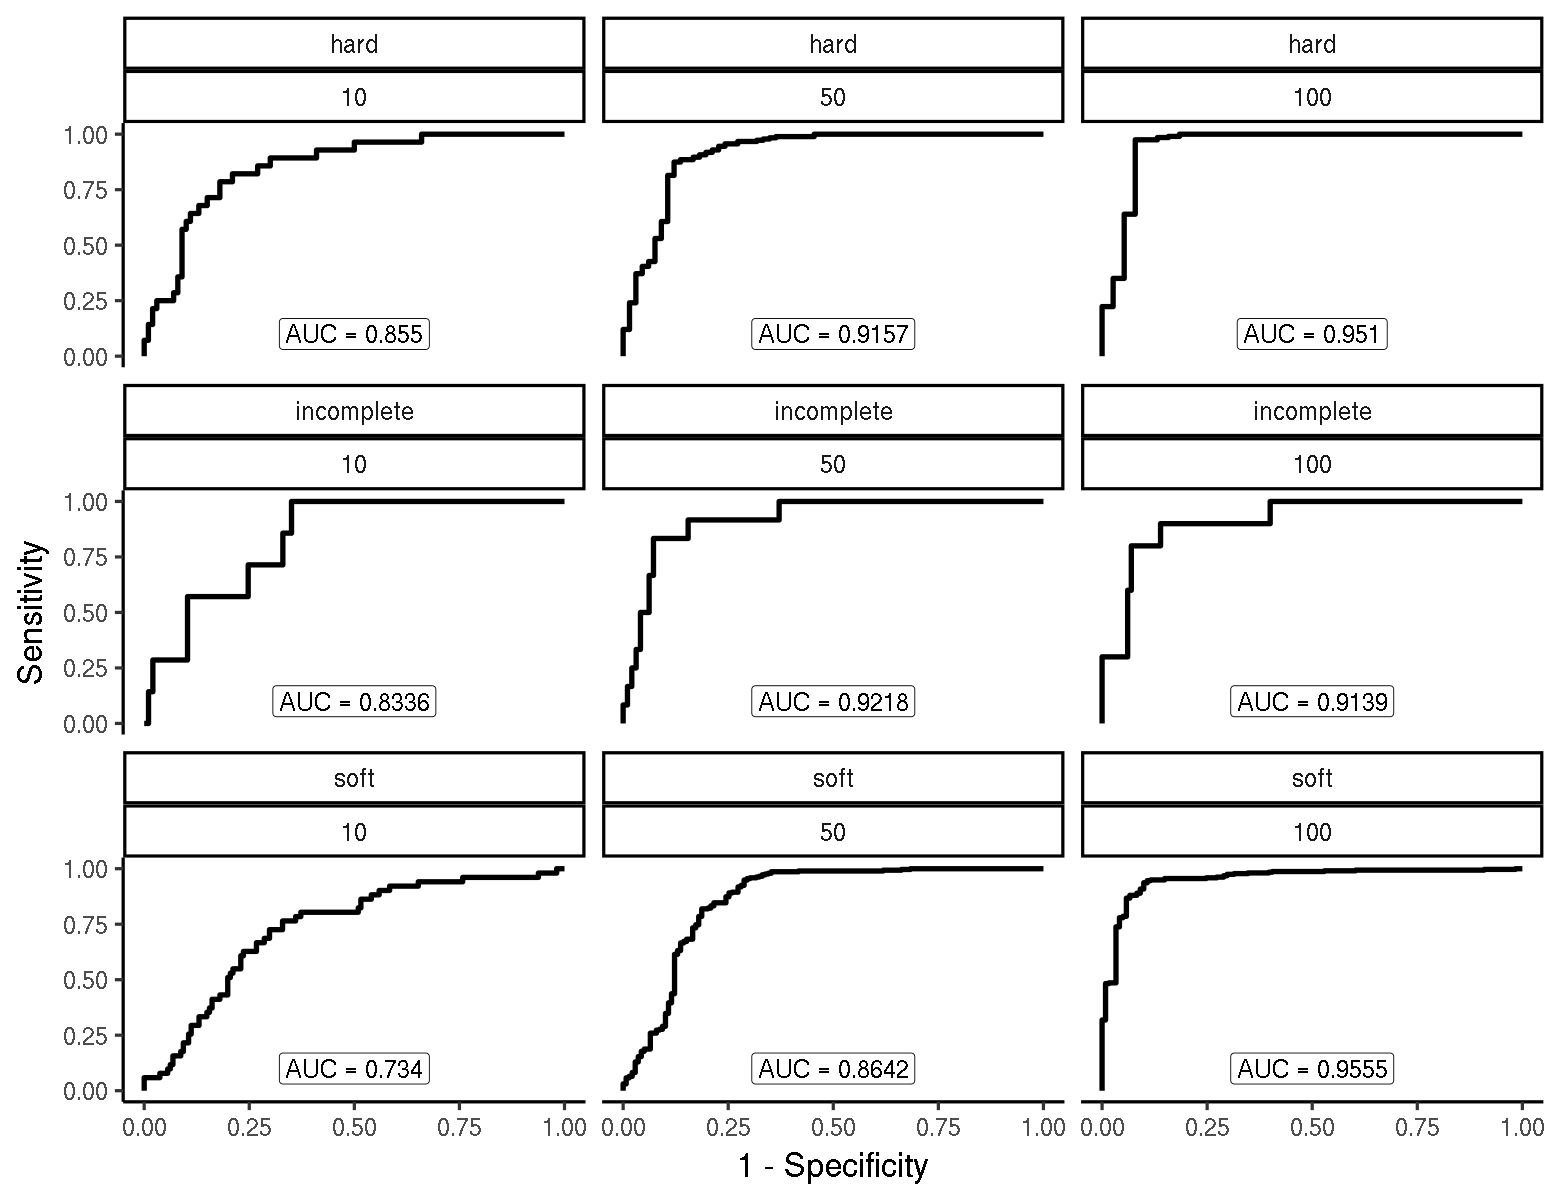

In [6]:
options(repr.plot.width=13, repr.plot.height=10)


#auc
auc_df <- full_df %>%
    group_by(sim_type, alpha) %>%  
    mutate(
        delta_specificity_1m = c(NA, specificity_1m[2:n()] - specificity_1m[1:(n()-1)]),
        sensitivity_sum = c(NA, sensitivity[2:n()] + sensitivity[1:(n()-1)]),
        auc = sensitivity_sum / 2 * delta_specificity_1m
    ) %>% 
    summarise(auc = round(sum(auc, na.rm = TRUE), 4)) %>% 
    ungroup()


full_df %>%
    arrange(sensitivity) %>% 
    ggplot(aes(specificity_1m, sensitivity)) +
    geom_line(lwd = 1.5) +
    geom_label(data = auc_df, aes(0.5,0.1, label = paste0("AUC = ", auc)), size = 6, inherit.aes = FALSE) +
    facet_wrap(~sim_type + as.numeric(alpha)) +
    xlab("1 - Specificity") +
    ylab("Sensitivity") +
    theme_set(theme_classic(18)) +
    ggsave("/home/stittes/parv_local_overleaf/corn_cab_elife/figures/supplement_auc.pdf", width = 13, height = 10)



In [15]:
tpr_table <- full_df %>% 
    group_by(alpha, sim_type) %>% 
    summarise(
        TPR = sum(truth_class == "true_positive", na.rm = TRUE) / (sum(truth_class == "true_positive", na.rm = TRUE) + sum(truth_class == "false_negative", na.rm = TRUE)),
        TNR = sum(truth_class == "true_negative", na.rm = TRUE) / (sum(truth_class == "true_negative", na.rm = TRUE) + sum(truth_class == "false_positive", na.rm = TRUE)),
        FNR = 1 - TPR,
        FPR = 1 - TNR
    ) %>% 
    arrange(sim_type, as.numeric(alpha))

print(xtable(tpr_table))

tpr_table

`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Sat Apr 29 10:48:20 2023
\begin{table}[ht]
\centering
\begin{tabular}{rllrrrr}
  \hline
 & alpha & sim\_type & TPR & TNR & FNR & FPR \\ 
  \hline
1 & 10 & hard & 0.14 & 0.67 & 0.86 & 0.33 \\ 
  2 & 50 & hard & 0.92 & 0.75 & 0.08 & 0.25 \\ 
  3 & 100 & hard & 0.99 & 0.84 & 0.01 & 0.16 \\ 
  4 & 10 & incomplete & 0.04 & 0.67 & 0.96 & 0.33 \\ 
  5 & 50 & incomplete & 0.06 & 0.67 & 0.94 & 0.33 \\ 
  6 & 100 & incomplete & 0.05 & 0.63 & 0.95 & 0.37 \\ 
  7 & 10 & soft & 0.13 & 0.71 & 0.87 & 0.29 \\ 
  8 & 50 & soft & 0.75 & 0.74 & 0.25 & 0.26 \\ 
  9 & 100 & soft & 0.81 & 0.76 & 0.19 & 0.24 \\ 
   \hline
\end{tabular}
\end{table}


alpha,sim_type,TPR,TNR,FNR,FPR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10,hard,0.1400000,0.6666667,0.86000000,0.3333333
50,hard,0.9150000,0.7518797,0.08500000,0.2481203
100,hard,0.9899497,0.8396624,0.01005025,0.1603376
10,incomplete,0.0350000,0.6734007,0.96500000,0.3265993
50,incomplete,0.0600000,0.6711864,0.94000000,0.3288136
100,incomplete,0.0500000,0.6325879,0.95000000,0.3674121
10,soft,0.1307692,0.7067395,0.86923077,0.2932605
50,soft,0.7493606,0.7377358,0.25063939,0.2622642
100,soft,0.8066158,0.7645914,0.19338422,0.2354086


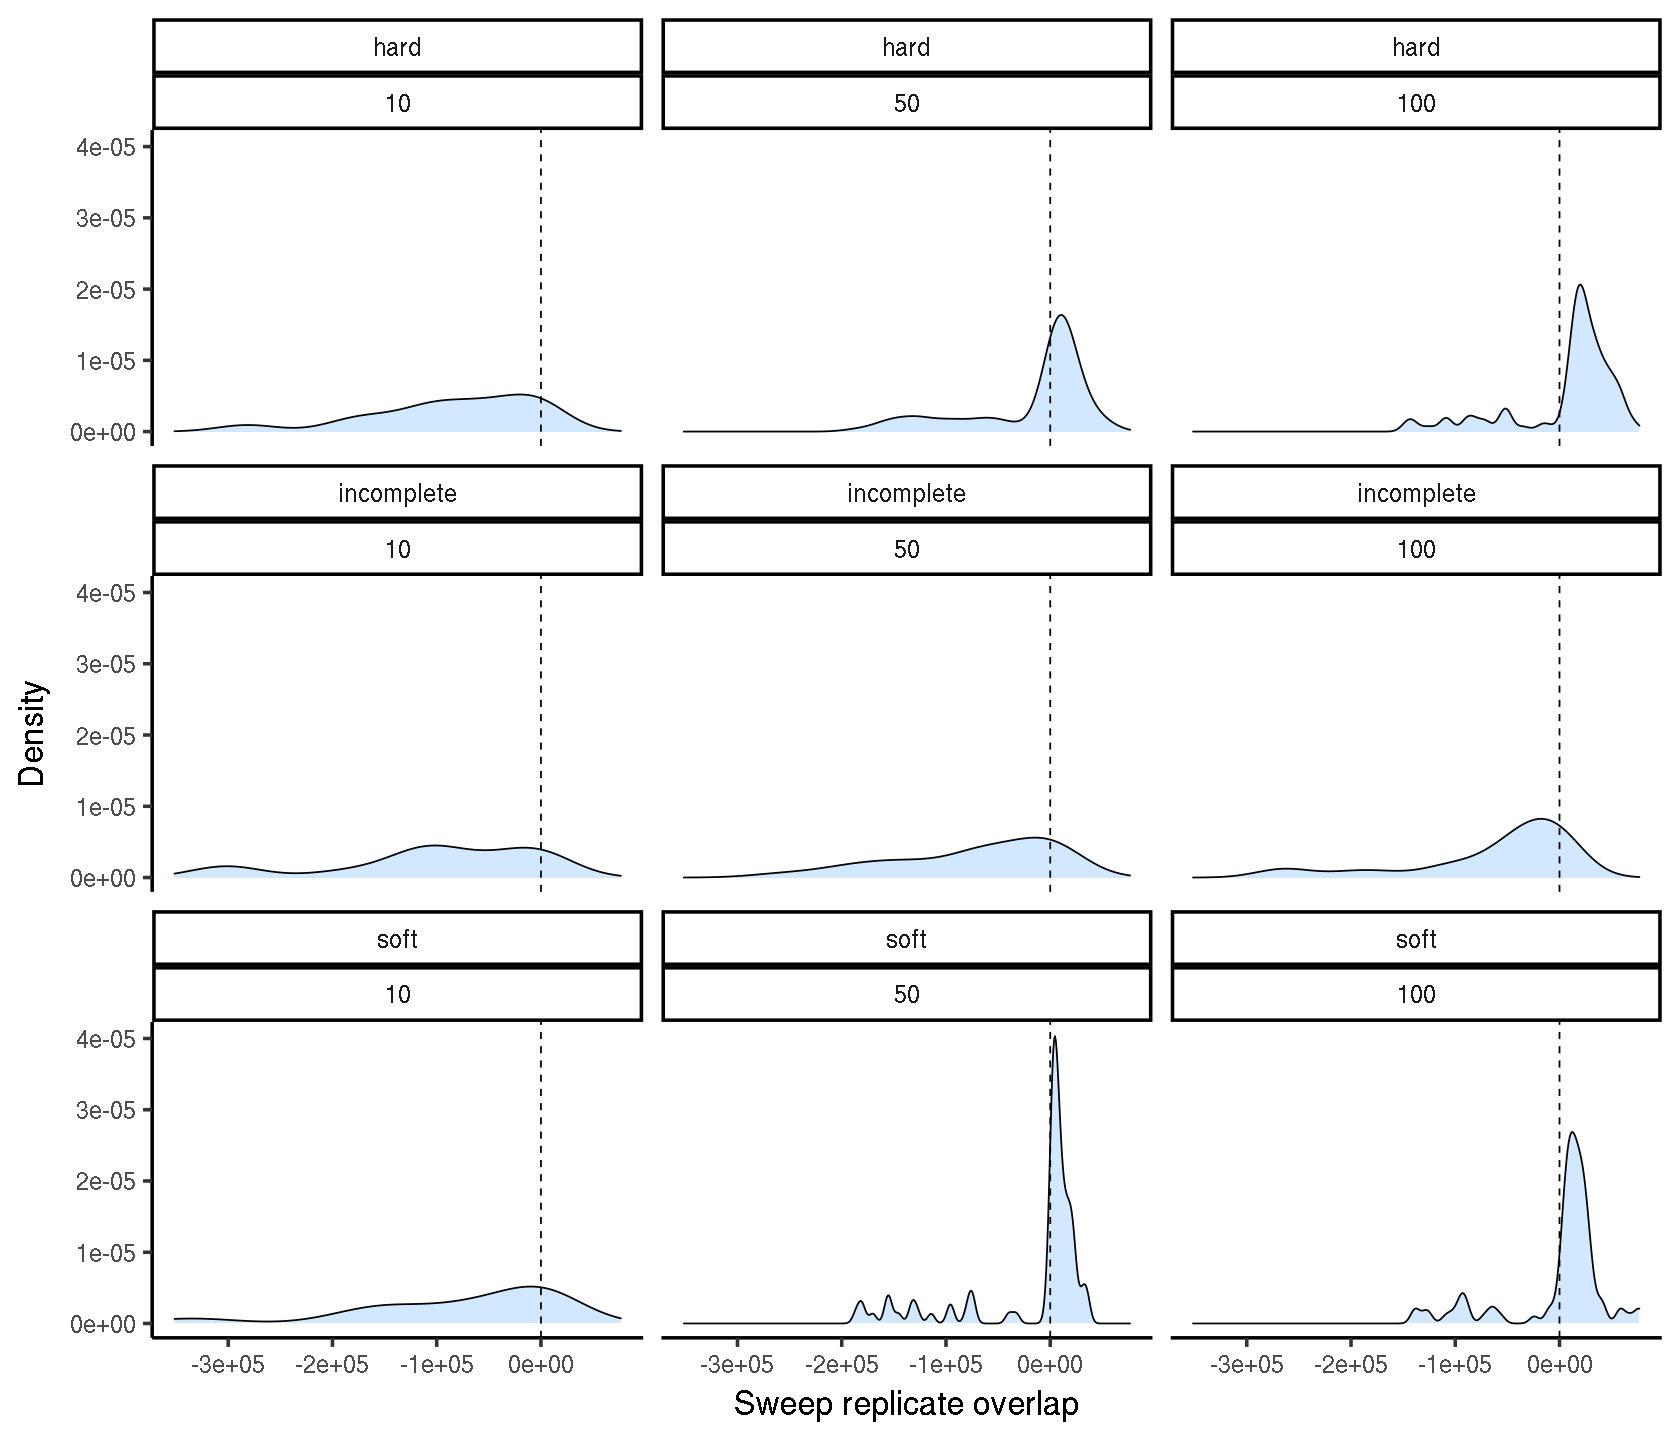

In [19]:
options(repr.plot.width=14, repr.plot.height=12)

#agreement between subreps 

#how to check similarity between two?
#Maybe number of shared bps?
#i.e.
# start end rep

#          s----------e
#             s-----e
#                s----------e
#        s-----e

#so difference between min end and max start?

reps_df <- full_df %>% 
    group_by(seed1, seed2, start_freq, end_freq, alpha, sim_type, sweep_group) %>% 
    mutate(count = length(sub)) %>% 
    filter(!is.na(sweep_group), count > 1) %>%
    mutate(replicate_overlap = (min(end) - max(start)), scaled_overlap = replicate_overlap / mean(sweep_size))


reps_df %>% 
    ggplot(aes(x = replicate_overlap)) + 
    geom_density(fill = "dodgerblue", alpha = 0.2) + 
    geom_vline(xintercept = 0, lty = 2) +
    facet_wrap(~sim_type + as.numeric(alpha), scales = "fixed") +
    xlab("Sweep replicate overlap") +
    ylab("Density") +
    ggsave("/home/stittes/parv_local_overleaf/corn_cab_elife/figures/supplement_sim_overlap.pdf", width = 14, height = 12)
    